In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('../images_video/calibration*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners2,ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()



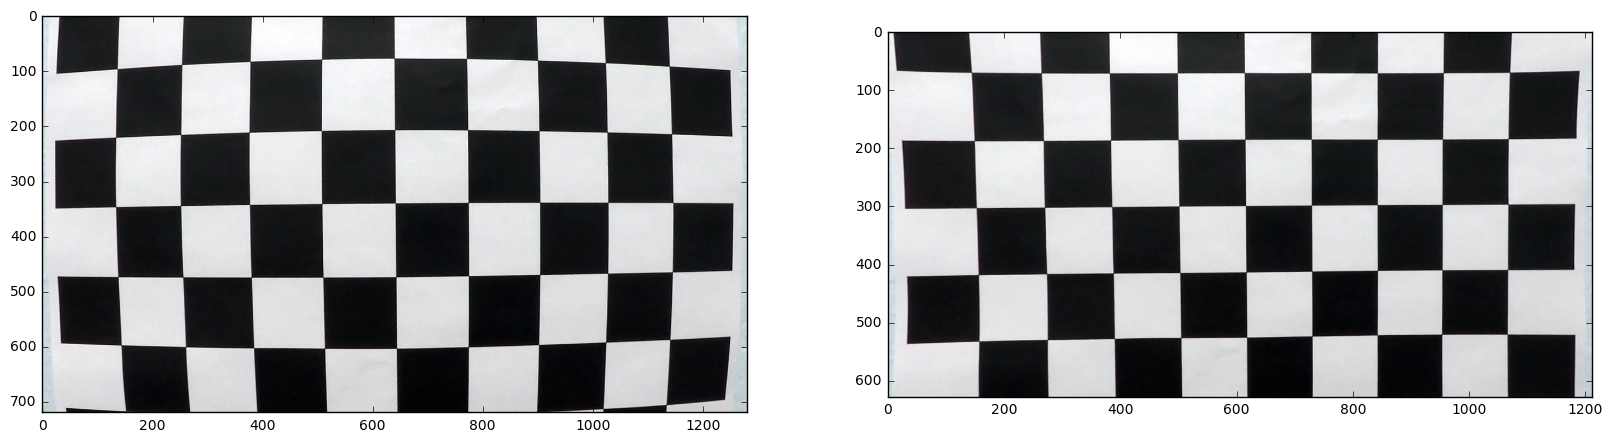

In [2]:
import pickle
%matplotlib inline

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
img = cv2.imread('../images_video/calibration1.jpg')
h,  w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('../images_video/cal1_undist.jpg',dst)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["rvecs"] = rvecs
dist_pickle["tvecs"] = tvecs
dist_pickle["newcameramtx"] = newcameramtx
dist_pickle["roi"] = roi
pickle.dump( dist_pickle, open( "dist_pickle.p", "wb" ) )

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax2.imshow(dst)

In [3]:
def warper(binary_img):

    # Define calibration box in source (actual) and destination (desired) coordinates
    img_size = (binary_img.shape[1], binary_img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 25, img_size[1] / 2 + 80],
         [((img_size[0] / 6) - 10), img_size[1]],
         [(img_size[0] * 5 / 6) + 60, img_size[1]],
         [(img_size[0] / 2 + 50), img_size[1] / 2 + 80]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])

    # Compute and apply perpective transform
    M = cv2.getPerspectiveTransform(src, dst)
    Minv =  cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(binary_img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return Minv, warped

def warp_points(x, y, M):
    # Expect x and y to be vectors and transform matrix M to be a 3x3
    xnew = (M[0][0]*x + M[0][1]*y + M[0][2])/(M[2][0]*x + M[2][1]*y + M[2][2])
    ynew = (M[1][0]*x + M[1][1]*y + M[1][2])/(M[2][0]*x + M[2][1]*y + M[2][2])
    
    return xnew, ynew

In [4]:
def region_of_interest(img, vertices):
    
    # Define a blank mask to start with
    mask = np.zeros(img.shape, np.float) 
    
    # Define a 3 channel or 1 channel fill color
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,)*channel_count
    else:
        ignore_mask_color = 255
        
    # Fill pixels inside the polygon defined by "vertices" with fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # Return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask.astype(img.dtype))
    return masked_image

def find_newgood(nzerox, nzeroy, startind, stopind, width, fit):
    
    # Extrapolate a fit to the lane line to include new pixels
    fitdeg = len(fit) - 1
    if fitdeg == 2:
        xfit = fit[0]*nzeroy**2 + fit[1]*nzeroy + fit[2]
    elif fitdeg == 1:
        xfit = fit[0]*nzeroy + fit[1] 
    good = ((nzerox >= (xfit - width)) \
                    & (nzerox <= (xfit + width)) \
                    & (nzeroy > startind) \
                    & (nzeroy <= stopind)).nonzero()[0]
    return good

def line_search(nzx, nzy, plx, prx, ystart_frac, startind, img_shape, margin):
    
    # Identify pixels associated with the base of the lane lines
    # first on the left
    good1 = ((nzx >= plx[0]) & (nzx <= plx[1]) & (nzy >= startind)).nonzero()[0]
    nonzero1x = nzx[good1]  
    nonzero1y = nzy[good1]    
    # then on the right
    good2 = ((nzx >= prx[0]) & (nzx <= prx[1]) & (nzy >= startind)).nonzero()[0]
    nonzero2x = nzx[good2]    
    nonzero2y = nzy[good2]    

    # Define the starting point for bins in y to iteratively find the lines
    next_ysfrac = ystart_frac - 0.1
    last_ysfrac = 0
    nsteps = 1 + next_ysfrac/0.1
    ystarts = np.linspace(next_ysfrac, last_ysfrac, nsteps, endpoint=True)
    dy = 1 - ystart_frac # y bin size
   
    for ys in ystarts:  # step through the bins in y
        
        order = 1    # order of the polynomial fit        
        line1 = np.polyfit(nonzero1y, nonzero1x, order) # fit a line to pixels in the base of left line
        startind = round(img_shape[0]*ys)   # start point of y bin
        stopind = round(img_shape[0]*(ys+dy))  # end point of y bin
        #select new set of pixels to add to the line
        new_good1 = find_newgood(nzx, nzy, startind, stopind, margin, line1)  
        if len(new_good1) > 0:  #if we found some, add them to the line
            if len(new_good1) > 10: #if we found more than 10 use them to define next line segment selection
                nonzero1x = nzx[new_good1]
                nonzero1y = nzy[new_good1]
            
            good1 = np.hstack((good1, new_good1))    
        
        # do the same for the right line
        line2 = np.polyfit(nonzero2y, nonzero2x, 1)
        new_good2 = find_newgood(nzx, nzy, startind, stopind, margin, line2)
        if len(new_good2) > 0:
            if len(new_good2) > 10:        
                nonzero2x = nzx[new_good2]
                nonzero2y = nzy[new_good2]
            good2 = np.hstack((good2, new_good2))    
 
    
    # Get rid of duplicates from overlapping bins
    return np.unique(good1), np.unique(good2)

def find_line_pixels(binimg):
    
    # Iterative method for finding pixels associated with the lane lines
    # Start point for finding the base of lane lines 
    # i.e. a value of 0.6 implies we'll search the bottom 40% of the image for the base of the lines
    img_shape = binimg.shape
    ystart_frac = 0.6
    startind = round(img_shape[0]*ystart_frac)
    
    # Define the bins in x where I expect to find the lines (based on prior knowledge)
    # TODO: replace this with a search informed by previous line position
    margin = 50 # width to include pixels left and right of the fit

    # Identify all nonzero pixels in the binary image
    nonzero = binimg.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    if lines_dict['best_left_fit'][0].any():

        leftfit = lines_dict['best_left_fit']
        rightfit = lines_dict['best_right_fit']

        good_left = ((nonzerox > (leftfit[0]*(nonzeroy**2) + leftfit[1]*nonzeroy + leftfit[2] - margin)) & \
                    (nonzerox < (leftfit[0]*(nonzeroy**2) + leftfit[1]*nonzeroy + leftfit[2] + margin)))
        good_right = ((nonzerox > (rightfit[0]*(nonzeroy**2) + rightfit[1]*nonzeroy + rightfit[2] - margin)) & \
                     (nonzerox < (rightfit[0]*(nonzeroy**2) + rightfit[1]*nonzeroy + rightfit[2] + margin)))
           
        # Identify all pixels associated with the lines
        left_line_x = nonzerox[good_left]
        left_line_y = nonzeroy[good_left]
        right_line_x = nonzerox[good_right]
        right_line_y = nonzeroy[good_right]

    else: 
        print('initializing line search...')
        pleftx = [round(img_shape[1]*0.2), round(img_shape[1]*0.4)]
        prightx = [round(img_shape[1]*0.7), round(img_shape[1]*0.85)]
        good_left, good_right = line_search(nonzerox, nonzeroy, pleftx, prightx, ystart_frac, startind, img_shape, margin)                
        # Identify all pixels associated with the lines
        left_line_x = nonzerox[good_left]
        left_line_y = nonzeroy[good_left]
        right_line_x = nonzerox[good_right]
        right_line_y = nonzeroy[good_right]
    
    # Fit a polynomial to all pixels and return the goods
    left_fit = np.polyfit(left_line_y, left_line_x, 2)
    right_fit = np.polyfit(right_line_y, right_line_x, 2)

    if lines_dict['current_leftfit'][0].any():
        
        diff_left = np.absolute(lines_dict['current_leftfit'] - left_fit)
        diff_right = np.absolute(lines_dict['current_rightfit'] - right_fit)
        lines_dict['diff_left'] = np.vstack((lines_dict['diff_left'], diff_left))
        lines_dict['diff_right'] = np.vstack((lines_dict['diff_right'], diff_right))

    
        if lines_dict['diff_left'].shape[0] > 10:
            left_std = np.std(lines_dict['diff_left'][:,0][-10:])
            
            if diff_left[0] < 4*left_std:
                lines_dict['current_leftfit'] = left_fit
                
        if lines_dict['diff_right'].shape[0] > 10:
            right_std = np.std(lines_dict['diff_right'][:,0][-10:])
           
            if diff_right[0] < 4*right_std:
                lines_dict['current_rightfit'] = right_fit
    else: 
        lines_dict['current_leftfit'] = left_fit
        lines_dict['current_rightfit'] = right_fit
    sample_loc = img_shape[0]
    left_curverad = ((1 + (2*left_fit[0]*sample_loc + left_fit[1])**2)**1.5)/np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*sample_loc + right_fit[1])**2)**1.5)/np.absolute(2*right_fit[0])
    pixels_to_meters = 1#img_shape[0]/30
    avg_curverad = (left_curverad + right_curverad)/2/pixels_to_meters
    lines_dict['radius_of_curvature'] = avg_curverad
    lines_dict['deg_per_meter'] = 360/(2*np.pi*avg_curverad)
    
    #print(lines_dict['rad_curvature'])
    return left_line_x, left_line_y, right_line_x, right_line_y


In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
#from scipy.interpolate import InterpolatedUnivariateSpline

#unpacking camera calibration data
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
roi = dist_pickle["roi"]
newcameramtx = dist_pickle["newcameramtx"]

#defining region of interest
vertices = np.array([[(110,719), (625, 430), (680, 430), (1260, 719)]], dtype=np.int32)



#lines_dict will hold running tally of recent lane position
dummy = [np.array([False])]
dummy2 = np.array([0,0,0], dtype='float')
lines_dict = {'vertices':vertices, 'nxleft_fitted':dummy, 'nxright_fitted':dummy, 'current_best_leftx':dummy, 'current_best_rightx':dummy,
              'best_left_fit':dummy, 'best_right_fit':dummy, 'radius_of_curvature': dummy, 'deg_per_meter': dummy,
              'current_y':dummy, 'current_leftfit':dummy, 'current_rightfit':dummy,'linepos_left':dummy, 
              'linepos_right':dummy, 'linepos_y':dummy, 'diff_left':dummy2, 'diff_right':dummy2}


def process_image(image):

    img_shape = image.shape
    # Undistort the image per camera calibration
    dst = cv2.undistort(image, mtx, dist, None, newcameramtx)
    x,y,w,h = roi

    # Clip image to flattened region and resize back to original dims
    dst = dst[y:y+h, x:x+w] 
    snapdst = cv2.resize(dst, (1280, 720))

    # Grayscale and derivatives (no longer Gaussian smoothing)
    gray = cv2.cvtColor(snapdst, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abssx = np.absolute(sobelx) #absolute x derivative to accentuate strong verticalish lines
    scale_factor = np.max(abssx)/255
    abssx = (abssx/scale_factor).astype(np.uint8) #rescaling to 8 bit 
    masked_abssx = region_of_interest(abssx, lines_dict['vertices']) #and masking
    masked_red = region_of_interest(snapdst[:,:,0], lines_dict['vertices']) #not masking red channel for now
    masked_orig = region_of_interest(snapdst, lines_dict['vertices']) #not masking red channel for now
    # Threshold red x gradient and red channel for lane pixel selection
    retval, sxbinary = cv2.threshold(masked_abssx, 20, 100, cv2.THRESH_BINARY)
    retval, redbinary = cv2.threshold(masked_red.astype('uint8'), 220, 255, cv2.THRESH_BINARY)
    redgrad_binary = np.clip(cv2.bitwise_or(redbinary, sxbinary), 0, 1).astype('uint8')

    # Warp and calculate inverse warp matrix
    Minv, warped = warper(redgrad_binary)

    # Find lane pixels
    nonzero1x, nonzero1y, nonzero2x, nonzero2y  = find_line_pixels(warped)

    # Generate lines to plot on warped image based on fit
    yfit = np.linspace(0, img_shape[0] - 1, img_shape[0]).astype('int')
    lfit = lines_dict['current_leftfit']
    rfit = lines_dict['current_rightfit']
    left_xfit = np.clip(np.round(lfit[0]*yfit**2 + lfit[1]*yfit + lfit[2]).astype('int'), 0, img_shape[1]-1)
    right_xfit = np.clip(np.round(rfit[0]*yfit**2 + rfit[1]*yfit + rfit[2]).astype('int'), 0, img_shape[1]-1)
    lines_dict['current_y'] = yfit

    smooth = 5
    if left_xfit.shape[0] > 0:
        if lines_dict['nxleft_fitted'][0].any():
            lines_dict['nxleft_fitted'].append(left_xfit)
        else:
            lines_dict['nxleft_fitted'] = [left_xfit]

        if len(lines_dict['nxleft_fitted']) > smooth:
            lines_dict['nxleft_fitted'] = lines_dict['nxleft_fitted'][-smooth:]   
        lines_dict['current_best_leftx'] = np.mean(np.array(lines_dict['nxleft_fitted']), axis=0).astype('int')
        #lines_dict['current_best_rightx'] = left_xfit
  
    if right_xfit.shape[0] > 0:
        if lines_dict['nxright_fitted'][0].any():
            lines_dict['nxright_fitted'].append(right_xfit)
        else:
            lines_dict['nxright_fitted'] = [right_xfit]
        if len(lines_dict['nxright_fitted']) > smooth:
            lines_dict['nxright_fitted'] = lines_dict['nxright_fitted'][-smooth:]    
        lines_dict['current_best_rightx'] = np.mean(np.array(lines_dict['nxright_fitted']), axis=0).astype('int')
        #lines_dict['current_best_rightx'] = interp_xright

    lines_dict['best_left_fit'] = np.polyfit(yfit, lines_dict['current_best_leftx'], 2)
    lines_dict['best_right_fit'] = np.polyfit(yfit, lines_dict['current_best_rightx'], 2)

    lines_dict['linepos_left'] = left_xfit #grab the left position of the most recent lane
    lines_dict['linepos_right'] = right_xfit #grab the right position of the most recent lane
    lines_dict['linepos_y'] = yfit
    
    # Generating some "slides" to plot color lines
    warp_copy1 = np.zeros(warped.shape, dtype='uint8')
    warp_copy2 = np.zeros(warped.shape, dtype='uint8')
    warp_copy3 = np.zeros(warped.shape, dtype='uint8')

    # plot right and left lines
    #warp_copy1[yfit, left_xfit] = 255
    #warp_copy1[yfit, right_xfit] = 255
    warp_copy2[nonzero1y, nonzero1x] = 255
    warp_copy3[nonzero2y, nonzero2x] = 255
    color_binary = np.dstack((warp_copy2, warp_copy1, warp_copy3)) 
    color_warped = np.dstack((warped, warped, warped))
    binresult = cv2.addWeighted(color_warped, 0.7, color_binary, 1, 0)

    # Unwarp slides back to image space
    unwarp_copy1 = cv2.warpPerspective(warp_copy1, Minv, 
                                       (img_shape[1], img_shape[0]), 
                                       flags=cv2.INTER_NEAREST)
    unwarp_copy2 = cv2.warpPerspective(warp_copy2, Minv, 
                                       (img_shape[1], img_shape[0]), 
                                       flags=cv2.INTER_NEAREST)
    unwarp_copy3 = cv2.warpPerspective(warp_copy3, Minv, 
                                       (img_shape[1], img_shape[0]), 
                                       flags=cv2.INTER_NEAREST)

    unwarp_xpix_left, unwarp_ypix  = warp_points(lines_dict['current_best_leftx'], yfit, Minv)
    unwarp_xpix_right, unwarp_ypix  = warp_points(lines_dict['current_best_rightx'], yfit, Minv)
    top = np.min(unwarp_ypix) 
    bottom = np.max(unwarp_ypix)

    n_ypts = bottom - top + 1      
    interp_y = np.linspace(top, bottom, n_ypts).astype('int')
    interp_xleft = np.round(np.interp(interp_y, unwarp_ypix, unwarp_xpix_left)).astype('int') 
    interp_xright = np.round(np.interp(interp_y, unwarp_ypix, unwarp_xpix_right)).astype('int')
        
    # Get our fitted lane lines into shape for cv2.fillPoly
    pts_left = np.array([np.transpose(np.vstack([interp_xleft, interp_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([interp_xright, interp_y])))])
    pts = np.hstack((pts_left, pts_right))
    
    top_window_extend = 20
    adjust = (interp_y - np.min(interp_y))/3
    offset = (adjust + top_window_extend).astype('int')
    verts_left = np.array([np.transpose(np.vstack([interp_xleft-offset, interp_y]))])
    verts_right = np.array([np.flipud(np.transpose(np.vstack([interp_xright+offset, interp_y])))])
    verts = np.hstack((verts_left, verts_right))
    lines_dict['vertices'] = verts

    line_drawn1 = np.zeros_like(unwarp_copy1)
    line_drawn2 = np.zeros_like(unwarp_copy1)
    line_drawn3 = np.zeros_like(unwarp_copy1)
    cv2.fillPoly(line_drawn2, pts, 255)

    lane_unwarp = np.dstack((line_drawn1, line_drawn2, line_drawn3)).astype('uint8')
    leftright_unwarp = np.dstack((unwarp_copy2, line_drawn1, unwarp_copy3)).astype('uint8')
    line_result = cv2.addWeighted(snapdst, 1, lane_unwarp, 0.3, 0)
    line_lr_result = cv2.addWeighted(line_result, 0.7, leftright_unwarp, 1, 0)
    curve_string = str(np.int(lines_dict['radius_of_curvature']))
    cv2.putText(line_lr_result,"Radius of Curvature = " + curve_string + '(m)', (50,50), 
                cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    
    lfit = lines_dict['best_left_fit']
    ycheck = np.int(img_shape[0]/2)
    xcheck = np.int(lfit[0]*ycheck**2 + lfit[1]*ycheck + lfit[2])
    curverad = np.int(((1 + (2*lfit[0]*ycheck + lfit[1])**2)**1.5)/np.absolute(2*lfit[0]))
    curve_string = str(np.int(curverad))
    cv2.circle(binresult,(xcheck+curverad, ycheck+800), curverad, (0,0,255), -1)
    cv2.putText(binresult,"Radius of Curvature = " + curve_string + '(m)', (50,50), 
                cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    
    #color_gradbin = np.dstack((redbinary, sxbinary*0, sxbinary)).astype('uint8')

    #reimage = cv2.resize(line_lr_result, (640, 360))
    #reout = cv2.resize(out, (640, 360))
    #redst = cv2.resize(snapdst, (640, 360))
    #rewarp = cv2.resize(warped, (640, 360))
    #resx = cv2.resize(sobelx, (640, 360))
    #rebinary = cv2.resize(binresult, (640, 360))
    #reredbin = cv2.resize(redbinary, (640, 360))
    #reredgrad = cv2.resize(color_gradbin, (640, 360))
    #resxbin = cv2.resize(sxbinary, (640, 360))
    #hsv = cv2.cvtColor(redst, cv2.COLOR_BGR2HSV)

    #return binresult
    return line_lr_result
    #return masked_orig
            

initializing line search...


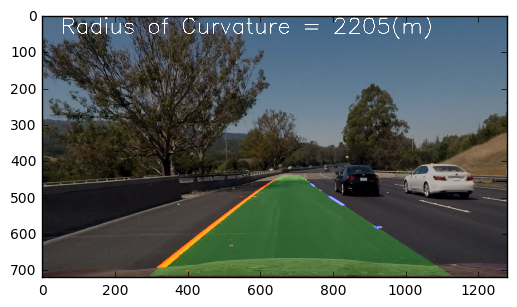

In [10]:
#img = mpimg.imread('../images_video/bridge_trees_example.jpg')
img = mpimg.imread('../images_video/bridge_trees_example.jpg')
out = process_image(img)
plt.imshow(out)

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#lines_dict will hold running tally of recent lane position
dummy = [np.array([False])]
dummy2 = np.array([0,0,0], dtype='float')
lines_dict = {'vertices':vertices, 'nxleft_fitted':dummy, 'nxright_fitted':dummy, 'current_best_leftx':dummy, 'current_best_rightx':dummy,
              'best_left_fit':dummy, 'best_right_fit':dummy, 'radius_of_curvature': dummy, 'deg_per_meter': dummy,
              'current_y':dummy, 'current_leftfit':dummy, 'current_rightfit':dummy,'linepos_left':dummy, 
              'linepos_right':dummy, 'linepos_y':dummy, 'diff_left':dummy2, 'diff_right':dummy2}

test_output = 'test.mp4'
clip = VideoFileClip("../images_video/challenge.mp4")
#clip = VideoFileClip("../images_video/bridge_shadow_Highway.mp4")
#clip = VideoFileClip("../images_video/curvy_mountain.mp4")
test_clip = clip.fl_image(process_image)
#%time 
test_clip.write_videofile(test_output, audio=False)

initializing line search...
[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|██████████| 251/251 [00:44<00:00,  5.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 



In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))